In [1]:
import sys
import os
sys.path.append('..')
import edlib
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy
import bisect


from sd_parser import SD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
from utils.os_utils import smart_makedirs
import networkx as nx
from debruijn_graph import DeBruijnGraph, iterative_graph, get_frequent_kmers, get_all_kmers

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Dataset

In [2]:
import pandas as pd
import numpy as np
import bisect

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
fasta_index_fn = "/Poppy/abzikadze/new_data/CHM13/nanopore/rel3/rel3_bgzip.fastq.gz.fai"

In [8]:
fasta_index = pd.read_csv(fasta_index_fn,
                          sep='\t',
                          names=["NAME", "LENGTH", "OFFSET", "LINEBASES", "LINEWIDTH", "QUALOFFSET"])

In [9]:
fasta_index.shape

(28449385, 6)

Total length

In [10]:
total_length = np.sum(fasta_index.LENGTH)
genome_len = 3.1 * 10**9
total_coverage = total_length / genome_len
print(total_length / 10**9, total_coverage)

367.2312828 118.461704129


N50:

In [11]:
sorted_lengths = np.sort(fasta_index.LENGTH)[::-1]
n50_index = bisect.bisect_left(np.cumsum(sorted_lengths), total_length / 2)
sorted_lengths[n50_index]

52930

In [12]:
max_short_len = 5000



Number of short reads


In [13]:
short_reads_index = fasta_index.LENGTH < max_short_len
np.sum(short_reads_index)

19283008



Coverage of human genome with short reads:


In [14]:
total_short_read_len = np.sum(fasta_index.LENGTH[short_reads_index])
total_short_read_len / genome_len

5.7382193370967745

Min long len

In [15]:
min_long_len = 50000



Number of long reads


In [16]:
long_reads_index = fasta_index.LENGTH > min_long_len
np.sum(long_reads_index)

1999007

Total length of long reads and coverage of human genome with long reads:

In [17]:
total_long_read_len = np.sum(fasta_index.LENGTH[long_reads_index])
total_long_read_len / 10**9, total_long_read_len / genome_len

(192.61815650599999, 62.134889195483872)

In [18]:
%reset -f 

# Recruitment of centromeric reads from cen6

In [19]:
import os
import pandas as pd
import numpy as np

In [446]:
centromeric_reads_dir = "/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191123/cen6_rel3_recruitment_thr550/reads"

! faidx {centromeric_reads_dir}/centromeric_reads.fasta > /dev/null



Traceback (most recent call last):
  File "/Users/andrewbzikadze/anaconda/envs/python3.6/lib/python3.6/site-packages/pyfaidx/__init__.py", line 359, in __init__
    if mutable else 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191123/cen6_rel3_recruitment_thr550/reads/centromeric_reads.fasta'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrewbzikadze/anaconda/envs/python3.6/bin/faidx", line 6, in <module>
    exit(main())
  File "/Users/andrewbzikadze/anaconda/envs/python3.6/lib/python3.6/site-packages/pyfaidx/cli.py", line 197, in main
    write_sequence(args)
  File "/Users/andrewbzikadze/anaconda/envs/python3.6/lib/python3.6/site-packages/pyfaidx/cli.py", line 21, in write_sequence
    fasta = Fasta(args.fasta, default_seq=args.default_seq, key_function=eval(args.header_function), strict_bounds=not args.lazy, split_char=args.delimiter

In [21]:
centromeric_reads_index_fn = \
    os.path.join(centromeric_reads_dir, 'centromeric_reads.fasta.fai')
centromeric_reads_index = pd.read_csv(centromeric_reads_index_fn,
                                     sep='\t',
                                     names=["NAME", "LENGTH", "OFFSET", "LINEBASES", "LINEWIDTH", "QUALOFFSET"])

In [22]:
nreads = centromeric_reads_index.shape[0]
nreads

6558

In [23]:
np.sum(centromeric_reads_index.LENGTH)

267720128

In [24]:
long_len = 50000

nlong = np.sum(centromeric_reads_index.LENGTH > long_len)

longest_len = np.max(centromeric_reads_index.LENGTH)
print(nlong, longest_len)

1621 530278


In [25]:
%reset -f

# Transforming reads into monoreads

In [3]:
import sys
sys.path.append('..')

import networkx as nx
import numpy as np

from debruijn_graph import DeBruijnGraph, get_frequent_kmers
# from sd_parser import SD_Report, get_stats
from sd_parser_83640e3 import SD_Report, get_stats
from mono_error_correction import error_correction


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [466]:
#sd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191120/SD_report/decomposition.tsv'
#sd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
# sd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191123/sd_d795adb_d6z1_rel3_karen/decomposition.tsv'
sd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191123/cen6_rel3_recruitment_thr550/sd_83640e3_cen6_rel3_thr550/decomposition.tsv'


monomers_fn = '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'


sd_report = SD_Report(SD_report_fn=sd_report_fn, monomers_fn=monomers_fn)
monoreads = sd_report.get_monomer_strings()


FileNotFoundError: [Errno 2] No such file or directory: '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'

In [5]:
get_stats(sd_report.get_monomer_strings(), verbose=True, return_stats=False)

Number of translations: 6558
Min length = 17
Mean length = 238.32464165904238
Max length = 3195
Total length = 1562933
#(%) Gap symbols = 34303 (0.021947837815184657)
#Gap runs = 7375


In [6]:
monoreads = error_correction(monoreads, verbose=True)

Stats for uncorrected reads
Number of translations: 6558
Min length = 17
Mean length = 238.32464165904238
Max length = 3195
Total length = 1562933
#(%) Gap symbols = 34303 (0.021947837815184657)
#Gap runs = 7375

Stats for filtered reads
Number of translations: 6537
Min length = 17
Mean length = 237.9418693590332
Max length = 3195
Total length = 1555426
#(%) Gap symbols = 33437 (0.02149700467910399)
#Gap runs = 7297

Stats for trimmed+filtered reads
Number of translations: 6537
Min length = 0
Mean length = 235.28805262352762
Max length = 3195
Total length = 1538078
#(%) Gap symbols = 20807 (0.013527922511082013)
#Gap runs = 6190

Stats for cut_gaprich_reads+trimmed+filtered reads
# cut reads = 124
# total cut parts = 188
Number of translations: 6412
Min length = 0
Mean length = 228.91593886462883
Max length = 2662
Total length = 1467809
#(%) Gap symbols = 5989 (0.004080231147240547)
#Gap runs = 3193

Stats for hor_corrected+cut_gaprich_reads+trimmed+filtered reads
Number of translation

HOR graph for MinMultShortKMer = 100, MinMultShortKMer = 1000

In [7]:
def hor_graph(min_mult):
    frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monoreads, k=3, min_mult=min_mult)
    db = DeBruijnGraph(k=3)
    db.add_kmers(frequent_kmers, coverage=frequent_kmers)

    hors, _ = db.get_contigs()
    day="20191124"
    !mkdir ../../experiments/{day}
    dot_fn = f'../../experiments/{day}/hor_db_{min_mult}.dot'
    pdf_fn = f'../../experiments/{day}/hor_db_{min_mult}.pdf'
    nx.drawing.nx_pydot.write_dot(db.graph, dot_fn)
    !dot -Tpdf {dot_fn} -o {pdf_fn} 
    return db

In [8]:
hor_graph(100)
hor_graph(5000)
pass

mkdir: cannot create directory ‘../../experiments/20191124’: File exists
mkdir: cannot create directory ‘../../experiments/20191124’: File exists


# Constructing iterative de Bruijn graphs of monoreads

In [13]:
import networkx as nx

from collections import defaultdict, Counter
from debruijn_graph import DeBruijnGraph, iterative_graph, scaffolding, read2scaffolds, cover_scaffolds_w_reads, extract_read_pseudounits, polish

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def statistics_gapfree_kmers(monoreads, k, gap_symb='?'):
    cnt_all, cnt_gapfree = 0, 0
    for monoread in monoreads.values():
        for i in range(len(monoread)-k+1):
            kmer = monoread[i:i+k]
            if gap_symb not in kmer:
                cnt_gapfree += 1
            cnt_all += 1
    return cnt_all, cnt_gapfree, cnt_gapfree / cnt_all

statistics_gapfree_kmers(monoreads, k=400)

(249119, 223020, 0.8952348074614943)

In [11]:
# frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monoreads, k=400, min_mult=5)
# db = DeBruijnGraph(k=400)
# db.add_kmers(frequent_kmers, coverage=frequent_kmers)

# hors, _ = db.get_contigs()
# !mkdir ../../experiments/20191123
# dot_fn = f'../../experiments/20191123/db.dot'
# pdf_fn = f'../../experiments/20191123/db.pdf'
# nx.drawing.nx_pydot.write_dot(db.graph, dot_fn)
# !dot -Tpdf {dot_fn} -o {pdf_fn} 

In [12]:
# long_monoreads = {r_id: monoread for r_id, monoread in monoreads.items() if len(monoread) >= 500}
# len(long_monoreads)

In [13]:
min_k, max_k = 100, 400
contigs, dbs, all_frequent_kmers, all_frequent_kmers_read_pos = \
    iterative_graph(monoreads, min_k=min_k, max_k=max_k,
                    outdir='../../experiments/20191124/cen6_rel3_recruitment_thr550_20191123/idb_ccfda62_sd_83640e3_cen6_rel3_thr550/',
                    min_mult=5)


k=100
#frequent kmers = 2658
#cc = 6
122
2
2
2
2
2

k=101
#frequent kmers = 2720
#cc = 5
148
2
2
2
2

k=102
#frequent kmers = 2783
#cc = 5
148
2
2
2
2

k=103
#frequent kmers = 2846
#cc = 5
141
2
2
2
2

k=104
#frequent kmers = 2915
#cc = 5
159
2
2
2
2

k=105
#frequent kmers = 2984
#cc = 4
157
2
2
2

k=106
#frequent kmers = 3054
#cc = 3
158
2
2

k=107
#frequent kmers = 3125
#cc = 4
157
2
2
2

k=108
#frequent kmers = 3197
#cc = 3
160
2
2

k=109
#frequent kmers = 3270
#cc = 3
157
2
2

k=110
#frequent kmers = 3343
#cc = 3
161
2
2

k=111
#frequent kmers = 3416
#cc = 3
160
2
2

k=112
#frequent kmers = 3489
#cc = 2
149
2

k=113
#frequent kmers = 3569
#cc = 3
175
2
2

k=114
#frequent kmers = 3649
#cc = 2
175
2

k=115
#frequent kmers = 3730
#cc = 2
160
2

k=116
#frequent kmers = 3819
#cc = 2
194
2

k=117
#frequent kmers = 3907
#cc = 2
190
2

k=118
#frequent kmers = 3996
#cc = 2
176
2

k=119
#frequent kmers = 4092
#cc = 2
205
2

k=120
#frequent kmers = 4188
#cc = 2
205
2

k=121
#frequent kmers =


k=307
#frequent kmers = 13865

k=308
#frequent kmers = 13881

k=309
#frequent kmers = 13897

k=310
#frequent kmers = 13913

k=311
#frequent kmers = 13929

k=312
#frequent kmers = 13945

k=313
#frequent kmers = 13961

k=314
#frequent kmers = 13977

k=315
#frequent kmers = 13993

k=316
#frequent kmers = 14009

k=317
#frequent kmers = 14025

k=318
#frequent kmers = 14041

k=319
#frequent kmers = 14057

k=320
#frequent kmers = 14073

k=321
#frequent kmers = 14089

k=322
#frequent kmers = 14105

k=323
#frequent kmers = 14121

k=324
#frequent kmers = 14137

k=325
#frequent kmers = 14153

k=326
#frequent kmers = 14168
#cc = 2
36
2

k=327
#frequent kmers = 14183
#cc = 2
36
2

k=328
#frequent kmers = 14198
#cc = 2
36
2

k=329
#frequent kmers = 14213
#cc = 2
36
2

k=330
#frequent kmers = 14228
#cc = 2
36
2

k=331
#frequent kmers = 14243
#cc = 2
36
2

k=332
#frequent kmers = 14258
#cc = 2
36
2

k=333
#frequent kmers = 14273
#cc = 2
36
2

k=334
#frequent kmers = 14288
#cc = 2
34
2

k=335
#frequen

In [14]:
db = DeBruijnGraph(k=400)
db.add_kmers(all_frequent_kmers[400], coverage=all_frequent_kmers[400])
db.collapse_nonbranching_paths()

In [15]:
mappings = db.map_reads(monoreads)

1 6412
2 6412
3 6412
4 6412
5 6412
6 6412
7 6412
8 6412
9 6412
10 6412
11 6412
12 6412
13 6412
14 6412
15 6412
16 6412
17 6412
18 6412
19 6412
20 6412
21 6412
22 6412
23 6412
24 6412
25 6412
26 6412
27 6412
28 6412
29 6412
30 6412
31 6412
32 6412
33 6412
34 6412
35 6412
36 6412
37 6412
38 6412
39 6412
40 6412
41 6412
42 6412
43 6412
44 6412
45 6412
46 6412
47 6412
48 6412
49 6412
50 6412
51 6412
52 6412
53 6412
54 6412
55 6412
56 6412
57 6412
58 6412
59 6412
60 6412
61 6412
62 6412
63 6412
64 6412
65 6412
66 6412
67 6412
68 6412
69 6412
70 6412
71 6412
72 6412
73 6412
74 6412
75 6412
76 6412
77 6412
78 6412
79 6412
80 6412
81 6412
82 6412
83 6412
84 6412
85 6412
86 6412
87 6412
88 6412
89 6412
90 6412
91 6412
92 6412
93 6412
94 6412
95 6412
96 6412
97 6412
98 6412
99 6412
100 6412
101 6412
102 6412
103 6412
104 6412
105 6412
106 6412
107 6412
108 6412
109 6412
110 6412
111 6412
112 6412
113 6412
114 6412
115 6412
116 6412
117 6412
118 6412
119 6412
120 6412
121 6412
122 6412
123 6412
1

1233 6412
1234 6412
1235 6412
1236 6412
1237 6412
1238 6412
1239 6412
1240 6412
1241 6412
1242 6412
1243 6412
1244 6412
1245 6412
1246 6412
1247 6412
1248 6412
1249 6412
1250 6412
1251 6412
1252 6412
1253 6412
1254 6412
1255 6412
1256 6412
1257 6412
1258 6412
1259 6412
1260 6412
1261 6412
1262 6412
1263 6412
1264 6412
1265 6412
1266 6412
1267 6412
1268 6412
1269 6412
1270 6412
1271 6412
1272 6412
1273 6412
1274 6412
1275 6412
1276 6412
1277 6412
1278 6412
1279 6412
1280 6412
1281 6412
1282 6412
1283 6412
1284 6412
1285 6412
1286 6412
1287 6412
1288 6412
1289 6412
1290 6412
1291 6412
1292 6412
1293 6412
1294 6412
1295 6412
1296 6412
1297 6412
1298 6412
1299 6412
1300 6412
1301 6412
1302 6412
1303 6412
1304 6412
1305 6412
1306 6412
1307 6412
1308 6412
1309 6412
1310 6412
1311 6412
1312 6412
1313 6412
1314 6412
1315 6412
1316 6412
1317 6412
1318 6412
1319 6412
1320 6412
1321 6412
1322 6412
1323 6412
1324 6412
1325 6412
1326 6412
1327 6412
1328 6412
1329 6412
1330 6412
1331 6412
1332 6412


2233 6412
2234 6412
2235 6412
2236 6412
2237 6412
2238 6412
2239 6412
2240 6412
2241 6412
2242 6412
2243 6412
2244 6412
2245 6412
2246 6412
2247 6412
2248 6412
2249 6412
2250 6412
2251 6412
2252 6412
2253 6412
2254 6412
2255 6412
2256 6412
2257 6412
2258 6412
2259 6412
2260 6412
2261 6412
2262 6412
2263 6412
2264 6412
2265 6412
2266 6412
2267 6412
2268 6412
2269 6412
2270 6412
2271 6412
2272 6412
2273 6412
2274 6412
2275 6412
2276 6412
2277 6412
2278 6412
2279 6412
2280 6412
2281 6412
2282 6412
2283 6412
2284 6412
2285 6412
2286 6412
2287 6412
2288 6412
2289 6412
2290 6412
2291 6412
2292 6412
2293 6412
2294 6412
2295 6412
2296 6412
2297 6412
2298 6412
2299 6412
2300 6412
2301 6412
2302 6412
2303 6412
2304 6412
2305 6412
2306 6412
2307 6412
2308 6412
2309 6412
2310 6412
2311 6412
2312 6412
2313 6412
2314 6412
2315 6412
2316 6412
2317 6412
2318 6412
2319 6412
2320 6412
2321 6412
2322 6412
2323 6412
2324 6412
2325 6412
2326 6412
2327 6412
2328 6412
2329 6412
2330 6412
2331 6412
2332 6412


3233 6412
3234 6412
3235 6412
3236 6412
3237 6412
3238 6412
3239 6412
3240 6412
3241 6412
3242 6412
3243 6412
3244 6412
3245 6412
3246 6412
3247 6412
3248 6412
3249 6412
3250 6412
3251 6412
3252 6412
3253 6412
3254 6412
3255 6412
3256 6412
3257 6412
3258 6412
3259 6412
3260 6412
3261 6412
3262 6412
3263 6412
3264 6412
3265 6412
3266 6412
3267 6412
3268 6412
3269 6412
3270 6412
3271 6412
3272 6412
3273 6412
3274 6412
3275 6412
3276 6412
3277 6412
3278 6412
3279 6412
3280 6412
3281 6412
3282 6412
3283 6412
3284 6412
3285 6412
3286 6412
3287 6412
3288 6412
3289 6412
3290 6412
3291 6412
3292 6412
3293 6412
3294 6412
3295 6412
3296 6412
3297 6412
3298 6412
3299 6412
3300 6412
3301 6412
3302 6412
3303 6412
3304 6412
3305 6412
3306 6412
3307 6412
3308 6412
3309 6412
3310 6412
3311 6412
3312 6412
3313 6412
3314 6412
3315 6412
3316 6412
3317 6412
3318 6412
3319 6412
3320 6412
3321 6412
3322 6412
3323 6412
3324 6412
3325 6412
3326 6412
3327 6412
3328 6412
3329 6412
3330 6412
3331 6412
3332 6412


4232 6412
4233 6412
4234 6412
4235 6412
4236 6412
4237 6412
4238 6412
4239 6412
4240 6412
4241 6412
4242 6412
4243 6412
4244 6412
4245 6412
4246 6412
4247 6412
4248 6412
4249 6412
4250 6412
4251 6412
4252 6412
4253 6412
4254 6412
4255 6412
4256 6412
4257 6412
4258 6412
4259 6412
4260 6412
4261 6412
4262 6412
4263 6412
4264 6412
4265 6412
4266 6412
4267 6412
4268 6412
4269 6412
4270 6412
4271 6412
4272 6412
4273 6412
4274 6412
4275 6412
4276 6412
4277 6412
4278 6412
4279 6412
4280 6412
4281 6412
4282 6412
4283 6412
4284 6412
4285 6412
4286 6412
4287 6412
4288 6412
4289 6412
4290 6412
4291 6412
4292 6412
4293 6412
4294 6412
4295 6412
4296 6412
4297 6412
4298 6412
4299 6412
4300 6412
4301 6412
4302 6412
4303 6412
4304 6412
4305 6412
4306 6412
4307 6412
4308 6412
4309 6412
4310 6412
4311 6412
4312 6412
4313 6412
4314 6412
4315 6412
4316 6412
4317 6412
4318 6412
4319 6412
4320 6412
4321 6412
4322 6412
4323 6412
4324 6412
4325 6412
4326 6412
4327 6412
4328 6412
4329 6412
4330 6412
4331 6412


5232 6412
5233 6412
5234 6412
5235 6412
5236 6412
5237 6412
5238 6412
5239 6412
5240 6412
5241 6412
5242 6412
5243 6412
5244 6412
5245 6412
5246 6412
5247 6412
5248 6412
5249 6412
5250 6412
5251 6412
5252 6412
5253 6412
5254 6412
5255 6412
5256 6412
5257 6412
5258 6412
5259 6412
5260 6412
5261 6412
5262 6412
5263 6412
5264 6412
5265 6412
5266 6412
5267 6412
5268 6412
5269 6412
5270 6412
5271 6412
5272 6412
5273 6412
5274 6412
5275 6412
5276 6412
5277 6412
5278 6412
5279 6412
5280 6412
5281 6412
5282 6412
5283 6412
5284 6412
5285 6412
5286 6412
5287 6412
5288 6412
5289 6412
5290 6412
5291 6412
5292 6412
5293 6412
5294 6412
5295 6412
5296 6412
5297 6412
5298 6412
5299 6412
5300 6412
5301 6412
5302 6412
5303 6412
5304 6412
5305 6412
5306 6412
5307 6412
5308 6412
5309 6412
5310 6412
5311 6412
5312 6412
5313 6412
5314 6412
5315 6412
5316 6412
5317 6412
5318 6412
5319 6412
5320 6412
5321 6412
5322 6412
5323 6412
5324 6412
5325 6412
5326 6412
5327 6412
5328 6412
5329 6412
5330 6412
5331 6412


In [31]:
# non_corrected_monoreads = sd_report.get_monomer_strings()
# ec_nohor_monoreads = error_correction(non_corrected_monoreads, verbose=True, hor_correction=False)


In [32]:
# ec_nohor_monoreads = {r_id: seq for r_id, seq in ec_nohor_monoreads.items() if len(seq) >= 1000}
# mappings_uncorrected = db.map_reads(ec_nohor_monoreads, verbose=False)

In [18]:
def get_edge_coverage(mappings):
    edge_coverage = defaultdict(int)
    for mapping in mappings.values():
        if mapping is None:
            continue
        _, _, valid_path, path = mapping
        if valid_path and len(path) >= 3:
            for edge in path:
                edge_coverage[edge] += 1
    # edge_coverage = dict(edge_coverage)
    return edge_coverage

In [19]:
# edge_coverage = get_edge_coverage(mappings_uncorrected)

In [20]:
# edge_coverage[(11515, 11722, 0)]

4

In [21]:
# edge_coverage[(11515, 11899, 0)]

4

In [22]:
# edge_coverage[(11722, 11899, 0)]

3

In [23]:
# edge_coverage[(11722, 1073, 0)]

1

In [24]:
# for e in db.graph.edges(keys=True):
#    if edge_coverage[e] == 0:
#        print(e)

In [25]:
def unique_edges_from_mapping(mappings, db):
    is_unique = {e: True for e in db.graph.edges(keys=True)}
    for r_id, mapping in mappings.items():
        if mapping is None:
            continue
        _, _, valid_path, path = mapping
        if valid_path:
            cnt_edges = Counter(path)
            for edge, cnt in cnt_edges.items():
                if cnt > 1:
                    is_unique[edge] = False
    unique = [e for e in is_unique if is_unique[e]]
    return unique

In [26]:
# unique_edges_from_mapping(mappings, db)

In [27]:
#mappings['ab79a298-1f1a-44da-a174-6a52ae8abfcd'] # entr -> A -> B
#mappings['aff6bdf9-4388-46e6-9aa5-af5c6c88258d'] # B -> C
#mappings['86fdd7a8-71b5-46fa-90d2-5e6888ae2289'] # D -> E
#mappings['6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9'] # F -> 
#mappings['bee10b9a-2130-48fe-ae17-ab10d9f1f4bf'] # -> G
#mappings['0b1f944b-90f7-4e17-a1cd-f02d38d0f84c'] # G -> H

#mappings['aff6bdf9-4388-46e6-9aa5-af5c6c88258d']
#mappings['86fdd7a8-71b5-46fa-90d2-5e6888ae2289']

In [33]:
scaffolds = scaffolding(db, mappings)
# scaffolds = scaffolding(db, mappings, additional_edges=[(5100, 4194, 1), (2743, 4926, 0)])
#scaffolds = scaffolding(db, mappings, additional_edges=[(2489, 6292, 0),
#                                                        (2692, 4926, 0),
#                                                        (5100, 4194, 1),
#                                                        (2743, 4926, 0),
#                                                        (5100, 4194, 0)])

(2743, 5969, 0) (6022, 13567, 0)
defaultdict(<class 'int'>, {((2743, 5969, 0), (5969, 5621, 0), (5621, 5630, 0), (5630, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 5657, 0), (5657, 6013, 0), (6013, 6022, 0), (6022, 13567, 0)): 4})

(1073, 2447, 0) (5672, 12476, 0)
defaultdict(<class 'int'>, {((1073, 2447, 0), (2447, 2489, 0), (2489, 5621, 0), (5621, 5630, 0), (5630, 920, 0), (920, 929, 0), (929, 914, 0), (914, 5657, 0), (5657, 5672, 0), (5672, 12476, 0)): 5})

(929, 918, 0) (5672, 5969, 0)
defaultdict(<class 'int'>, {((929, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919, 0), (919, 920, 0), (920, 929, 0), (929, 914, 0), (914, 918, 0), (918, 919,

In [480]:
# scaffolds_mapping = \
#     db.map_reads({i: scaffold for i, scaffold in enumerate(scaffolds)})

In [486]:
[len(scaffold) for scaffold in scaffolds]

[2, 2]

In [34]:
[len(scaffold) for scaffold in scaffolds[0]]

[5582, 11156]

In [37]:
# scaffolds[1][0]

In [38]:
# scaffolds[1][1]

# Polishing

In [6]:
from sd_parser_83640e3 import SD_Report, get_stats
from mono_error_correction import error_correction
import subprocess

from utils.bio import read_bio_seqs

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# sd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191123/cen6_rel3_recruitment_thr550/sd_83640e3_cen6_rel3_thr550/decomposition.tsv'
sd_report_fn = '../../sd_83640e3_cen6_rel3_thr550_decomposition.tsv'

# monomers_fn = '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'
monomers_fn = '../../inferred_monomers_single.fa'

sd_report = SD_Report(SD_report_fn=sd_report_fn, monomers_fn=monomers_fn)
# monoreads = sd_report.get_monomer_strings()
monomers = read_bio_seqs(monomers_fn)

In [8]:
ec_monostrings = error_correction(sd_report.monostrings, verbose=True, inplace=False)

Stats for uncorrected reads
Number of translations: 6558
Min length = 17
Mean length = 238.32464165904238
Max length = 3195
Total length = 1562933
#(%) Gap symbols = 34303 (0.021947837815184657)
#Gap runs = 7375

Stats for filtered reads
Number of translations: 6537
Min length = 17
Mean length = 237.9418693590332
Max length = 3195
Total length = 1555426
#(%) Gap symbols = 33437 (0.02149700467910399)
#Gap runs = 7297

Stats for trimmed+filtered reads
Number of translations: 6537
Min length = 0
Mean length = 235.28805262352762
Max length = 3195
Total length = 1538078
#(%) Gap symbols = 20807 (0.013527922511082013)
#Gap runs = 6190

Stats for cut_gaprich_reads+trimmed+filtered reads
# cut reads = 124
# total cut parts = 188
Number of translations: 6412
Min length = 0
Mean length = 228.91593886462883
Max length = 2662
Total length = 1467809
#(%) Gap symbols = 5989 (0.004080231147240547)
#Gap runs = 3193

Stats for hor_corrected+cut_gaprich_reads+trimmed+filtered reads
Number of translation

In [9]:
min_k, max_k = 100, 400
contigs, dbs, all_frequent_kmers, all_frequent_kmers_read_pos = \
    iterative_graph(ec_monostrings, min_k=min_k, max_k=max_k,
                    outdir='../../experiments/20191128/cen6_rel3_recruitment_thr550_20191123/idb_2a1ab9e_sd_83640e3_cen6_rel3_thr550/',
                    min_mult=5)


k=100
#frequent kmers = 2654
#cc = 8
123
2
2
2
2
2
2
2

k=101
#frequent kmers = 2714
#cc = 7
149
2
2
2
2
2
2

k=102
#frequent kmers = 2775
#cc = 7
149
2
2
2
2
2
2

k=103
#frequent kmers = 2836
#cc = 7
142
2
2
2
2
2
2

k=104
#frequent kmers = 2902
#cc = 7
158
2
2
2
2
2
2

k=105
#frequent kmers = 2968
#cc = 6
156
2
2
2
2
2

k=106
#frequent kmers = 3035
#cc = 4
157
2
2
2

k=107
#frequent kmers = 3104
#cc = 5
156
2
2
2
2

k=108
#frequent kmers = 3174
#cc = 4
158
2
2
2

k=109
#frequent kmers = 3246
#cc = 4
158
2
2
2

k=110
#frequent kmers = 3316
#cc = 5
158
2
2
4
2

k=111
#frequent kmers = 3386
#cc = 5
157
2
2
3
2

k=112
#frequent kmers = 3455
#cc = 3
146
2
2

k=113
#frequent kmers = 3533
#cc = 4
172
2
2
2

k=114
#frequent kmers = 3611
#cc = 3
172
2
2

k=115
#frequent kmers = 3690
#cc = 3
157
2
2

k=116
#frequent kmers = 3777
#cc = 3
191
2
2

k=117
#frequent kmers = 3863
#cc = 3
187
2
2

k=118
#frequent kmers = 3950
#cc = 3
174
2
2

k=119
#frequent kmers = 4044
#cc = 3
202
2
2

k=120
#freq


k=304
#frequent kmers = 13817

k=305
#frequent kmers = 13833

k=306
#frequent kmers = 13849

k=307
#frequent kmers = 13865

k=308
#frequent kmers = 13881

k=309
#frequent kmers = 13897

k=310
#frequent kmers = 13913

k=311
#frequent kmers = 13929

k=312
#frequent kmers = 13945

k=313
#frequent kmers = 13961

k=314
#frequent kmers = 13977

k=315
#frequent kmers = 13993

k=316
#frequent kmers = 14009

k=317
#frequent kmers = 14025

k=318
#frequent kmers = 14041

k=319
#frequent kmers = 14057

k=320
#frequent kmers = 14073

k=321
#frequent kmers = 14089

k=322
#frequent kmers = 14105

k=323
#frequent kmers = 14121

k=324
#frequent kmers = 14137

k=325
#frequent kmers = 14153

k=326
#frequent kmers = 14168
#cc = 2
36
2

k=327
#frequent kmers = 14183
#cc = 2
36
2

k=328
#frequent kmers = 14198
#cc = 2
36
2

k=329
#frequent kmers = 14213
#cc = 2
36
2

k=330
#frequent kmers = 14228
#cc = 2
36
2

k=331
#frequent kmers = 14243
#cc = 2
36
2

k=332
#frequent kmers = 14258
#cc = 2
36
2

k=333
#fr

In [10]:
db = DeBruijnGraph(k=400)
db.add_kmers(all_frequent_kmers[400], coverage=all_frequent_kmers[400])
db.collapse_nonbranching_paths()

In [35]:
mappings = db.map_reads(ec_monostrings, verbose=False)

In [36]:
scaffolds, edge_scaffolds = scaffolding(db, mappings)

In [45]:
# Manual connection of two scaffolds
cen6_scaffold = scaffolds[1] + scaffolds[0][399:]
cen6_edge_scaffold = edge_scaffolds[1] + edge_scaffolds[0]

In [55]:
r2s = read2scaffolds(db, [cen6_edge_scaffold], mappings, ec_monostrings)

In [56]:
{k[0]: v[1:] for k, v in r2s.items()}

{'0021a9f8-60a4-477a-866f-4d324a2701c1': (9665, 10113),
 '00739941-c14c-40bd-9fad-fabff753795b': (512, 1309),
 '01f80610-395e-4ef8-93d0-526989b8cb53': (3863, 5071),
 '03fc74e3-e1a8-413b-b35b-c7b152131e21': (14200, 14629),
 '04203cad-4a32-4b9c-b7dd-c8603e54b46b': (13851, 14306),
 '04b2f961-f6b4-438d-9a64-83dbd6049ffc': (15534, 16332),
 '04df92e4-2b55-4714-9075-54ba2fa83520': (6212, 6701),
 '050b88c4-e343-431d-99dc-4b8151b4adef': (14094, 14800),
 '0540aa3e-f34b-4e74-a5e5-884b69594a0d': (15178, 15818),
 '054f1983-9204-4889-936a-64ab45e7810c': (9624, 10324),
 '0569becf-f836-4ae1-9bfa-d1a7140a35ad': (1137, 1639),
 '057047e6-eb15-4d39-b4f6-473ecba0558a': (12427, 13051),
 '057e0adf-4419-4c35-840a-23acc7a5b2a4': (13020, 13465),
 '05c5a912-42ad-4a57-ae81-0a318dc8c6b7': (8721, 9585),
 '063b3d2c-c9b3-4292-861f-2839fc294b2b': (11894, 12535),
 '071a364c-8a2b-4c13-94af-87c957c392b9': (14798, 15262),
 '079aa8c8-90a4-4fe8-af37-d9170f7d82b7': (3357, 4333),
 '088f0475-2162-4143-93e1-26253961e1cc': (1573

In [57]:
scaf_read_coverage = cover_scaffolds_w_reads(r2s, mappings, [cen6_scaffold], ec_monostrings, k=db.k)

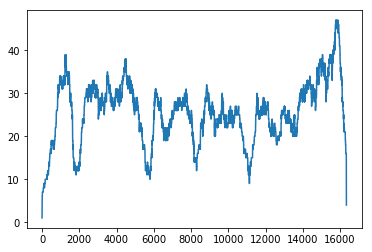

In [58]:
plt.plot([len(x) for x in scaf_read_coverage[0]])

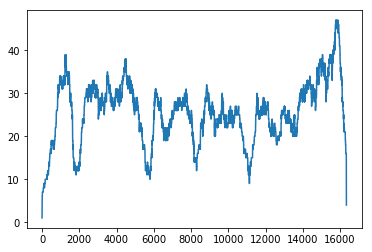

In [59]:
plt.plot([len(x) for x in scaf_read_coverage[0]])

In [60]:
pseudounits, read_pseudounits = extract_read_pseudounits(scaf_read_coverage, [cen6_scaffold],
                                                         monostrings=ec_monostrings)

In [61]:
centromeric_reads_fn = '../../centromeric_reads.fasta'
centromeric_reads = read_bio_seqs(centromeric_reads_fn)

In [62]:
print(len(pseudounits[0]))

962


In [63]:
polish(scaffolds=[cen6_scaffold],
       pseudounits=pseudounits,
       read_pseudounits=read_pseudounits,
       reads=centromeric_reads,
       monomers=monomers,
       outdir='../../polishing_cen6_20111206')

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_0/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_0/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_0
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_1/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_1/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_1
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_2/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_2/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_2
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_3/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_3/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_3
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudou

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_35/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_35/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_35
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_36/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_36/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_36
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_37/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_37/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_37
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_38/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_38/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_38
flye --nano-raw ../../polishing_cen6_20111206/scaffo

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_70/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_70/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_70
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_71/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_71/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_71
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_72/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_72/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_72
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_73/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_73/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_73
flye --nano-raw ../../polishing_cen6_20111206/scaffo

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_105/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_105/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_105
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_106/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_106/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_106
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_107/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_107/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_107
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_108/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_108/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_108
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_140/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_140/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_140
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_141/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_141/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_141
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_142/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_142/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_142
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_143/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_143/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_143
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_175/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_175/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_175
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_176/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_176/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_176
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_177/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_177/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_177
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_178/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_178/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_178
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_210/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_210/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_210
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_211/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_211/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_211
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_212/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_212/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_212
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_213/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_213/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_213
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_245/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_245/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_245
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_246/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_246/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_246
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_247/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_247/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_247
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_248/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_248/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_248
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_280/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_280/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_280
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_281/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_281/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_281
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_282/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_282/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_282
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_283/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_283/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_283
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_315/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_315/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_315
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_316/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_316/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_316
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_317/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_317/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_317
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_318/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_318/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_318
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_350/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_350/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_350
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_351/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_351/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_351
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_352/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_352/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_352
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_353/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_353/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_353
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_385/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_385/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_385
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_386/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_386/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_386
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_387/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_387/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_387
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_388/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_388/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_388
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_420/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_420/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_420
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_421/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_421/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_421
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_422/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_422/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_422
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_423/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_423/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_423
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_455/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_455/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_455
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_456/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_456/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_456
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_457/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_457/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_457
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_458/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_458/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_458
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_490/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_490/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_490
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_491/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_491/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_491
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_492/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_492/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_492
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_493/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_493/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_493
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_525/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_525/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_525
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_526/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_526/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_526
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_527/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_527/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_527
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_528/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_528/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_528
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_560/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_560/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_560
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_561/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_561/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_561
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_562/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_562/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_562
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_563/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_563/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_563
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_595/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_595/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_595
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_596/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_596/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_596
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_597/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_597/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_597
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_598/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_598/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_598
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_630/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_630/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_630
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_631/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_631/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_631
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_632/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_632/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_632
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_633/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_633/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_633
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_665/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_665/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_665
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_666/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_666/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_666
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_667/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_667/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_667
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_668/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_668/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_668
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_700/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_700/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_700
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_701/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_701/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_701
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_702/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_702/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_702
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_703/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_703/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_703
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_735/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_735/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_735
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_736/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_736/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_736
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_737/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_737/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_737
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_738/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_738/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_738
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_770/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_770/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_770
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_771/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_771/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_771
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_772/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_772/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_772
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_773/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_773/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_773
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_805/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_805/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_805
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_806/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_806/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_806
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_807/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_807/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_807
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_808/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_808/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_808
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_840/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_840/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_840
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_841/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_841/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_841
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_842/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_842/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_842
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_843/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_843/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_843
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_875/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_875/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_875
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_876/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_876/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_876
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_877/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_877/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_877
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_878/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_878/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_878
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_910/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_910/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_910
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_911/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_911/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_911
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_912/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_912/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_912
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_913/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_913/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_913
flye --nano-raw ../../polishing_cen6_201

flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_945/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_945/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_945
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_946/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_946/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_946
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_947/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_947/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_947
flye --nano-raw ../../polishing_cen6_20111206/scaffold_0/pseudounit_948/reads.fasta --polish-target ../../polishing_cen6_20111206/scaffold_0/pseudounit_948/template.fasta -i 1 -t 8 -o ../../polishing_cen6_20111206/scaffold_0/pseudounit_948
flye --nano-raw ../../polishing_cen6_201

In [677]:
len(cen6_scaffold)

16339